# Hospital - Error Detection using LSTMs for 10 attributes
This notebook demonstrates how we use record embeddings to perform error detection in tuples. We are using the **Hospital** dataset which has been artificially augmented to contain the following type of errors:
1. 17% of the tuples have been shuffled across the columnar axis.
2. 16% of the tuples has a cell value assigned to NaN.
3. 17% of the tuples has a cell value misspelt.

By converting each tuple to a space separated string and feeding it to an LSTM, we see if the network can learn to detect errors in the tuples.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import h5py
import pickle
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import models
from keras import layers
from keras import optimizers
from keras import activations
from keras import losses
from keras import metrics
from keras.utils import to_categorical

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Read the data

In [2]:
df = pd.read_csv('2k_tuples_bigger_dataset.csv', encoding='utf8',dtype=object)

In [3]:
df.head(3)

,ProviderNumber,HospitalName,Address1,City,ZipCode,CountyName,PhoneNumber,HospitalOwner,Condition,Sample,label
0,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,35631,LAUDERDALE,2567688400,Voluntary non-profit - Other,Surgical Infection Prevention,462 patients,1.0
1,10086,NORTHWEST MEDICAL CENTER,1530 U S HIGHWAY 43,WINFIELD,35594,MARION,2054877736,Proprietary,Heart Attack,8 patients,1.0
2,10032,WEDOWEE HOSPITAL,209 NORTH MAIN STREET,WEDOWEE,NaN,RANDOLPH,2563572111,Government - Local,Surgical Infection Prevention,Empty,0.0


In [6]:
len(df)

2000

In [7]:
df['label'].value_counts()

1.0    1100
0.0     900
Name: label, dtype: int64

In [8]:
df['PhoneNumber'].fillna(0, inplace=True)
df['ProviderNumber'].fillna(0, inplace=True)
df['ZipCode'].fillna(0, inplace=True)

### Separate the labels from the training data

In [10]:
df['label'] = df['label'].apply(lambda x: int(float(x)))
labels = np.asarray(df['label'].tolist())

In [13]:
df.drop(columns=['label'], axis=1, inplace=True)

### Convert PhoneNumber, ProviderNumber and ZipCode to int

In [14]:
df['ProviderNumber'] = df['ProviderNumber'].apply(lambda x: int(x))
df['PhoneNumber'] = df['PhoneNumber'].apply(lambda x: int(x))
df['ZipCode'] = df['ZipCode'].apply(lambda x: int(x))

In [16]:
df.head(3)

,ProviderNumber,HospitalName,Address1,City,ZipCode,CountyName,PhoneNumber,HospitalOwner,Condition,Sample
0,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,35631,LAUDERDALE,2567688400,Voluntary non-profit - Other,Surgical Infection Prevention,462 patients
1,10086,NORTHWEST MEDICAL CENTER,1530 U S HIGHWAY 43,WINFIELD,35594,MARION,2054877736,Proprietary,Heart Attack,8 patients
2,10032,WEDOWEE HOSPITAL,209 NORTH MAIN STREET,WEDOWEE,0,RANDOLPH,2563572111,Government - Local,Surgical Infection Prevention,Empty


### Replace 'Empty' in Sample attribute to '0 patients'

In [17]:
df['Sample'] = df['Sample'].replace('Empty','0 patients')

In [18]:
df.head(3)

,ProviderNumber,HospitalName,Address1,City,ZipCode,CountyName,PhoneNumber,HospitalOwner,Condition,Sample
0,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,35631,LAUDERDALE,2567688400,Voluntary non-profit - Other,Surgical Infection Prevention,462 patients
1,10086,NORTHWEST MEDICAL CENTER,1530 U S HIGHWAY 43,WINFIELD,35594,MARION,2054877736,Proprietary,Heart Attack,8 patients
2,10032,WEDOWEE HOSPITAL,209 NORTH MAIN STREET,WEDOWEE,0,RANDOLPH,2563572111,Government - Local,Surgical Infection Prevention,0 patients


### Convert each row to a space separated string

In [20]:
dfList = df.values.tolist()

In [21]:
rows = []
for row in dfList:
    combined = ','.join([str(x) for x in row])
    rows.append(combined)

In [22]:
len(rows)

2000

In [23]:
rows[0]

'10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,35631,LAUDERDALE,2567688400,Voluntary non-profit - Other,Surgical Infection Prevention,462 patients'

In [24]:
max([len(r) for r in rows])

189

### Save the dataset

In [25]:
df.to_csv("HospitalTrainingDataMultiAttributes.csv", encoding='utf8', index=False)

## Tokenize the data

Since the max length of a row is 189, we can set the maxSequenceLength as 200

In [27]:
maxSequenceLength = 200
maxWords = 5000

In [29]:
tokenizer = Tokenizer(num_words=maxWords, split=',')
tokenizer.fit_on_texts(rows)
sequences = tokenizer.texts_to_sequences(rows)
word_index = tokenizer.word_index

In [30]:
len(word_index)

916

In [31]:
data = pad_sequences(sequences, maxlen=maxSequenceLength)

In [32]:
data.shape

(2000, 200)

In [33]:
labels.shape

(2000,)

## Train test split

### Shuffle the data

In [34]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)

In [35]:
data = data[indices]
labels = labels[indices]

In [36]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=22, stratify=labels)

In [37]:
len(X_train), len(y_train)

(1600, 1600)

In [38]:
len(X_test), len(y_test)

(400, 400)

## Model
**Architecture**
* 1 Embedding layer
* 1 Bidirectional LSTM layer
* 1 output layer, _sigmoid_ activation
* Optimizer: Adam (learning rate = 0.01)
* Loss function: Binary crossentropy loss

In [72]:
embeddingDim = 100

In [73]:
model = models.Sequential()
model.add(layers.Embedding(1500, embeddingDim, input_length=maxSequenceLength))
model.add(layers.Bidirectional(layers.LSTM(64)))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1, activation=activations.sigmoid))
model.compile(optimizer=optimizers.Adam(lr=0.001), loss=losses.binary_crossentropy, metrics=[metrics.binary_accuracy])

In [74]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 200, 100)          150000    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 128)               84480     
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 235,121
Trainable params: 234,865
Non-trainable params: 256
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train,
                    epochs=15,
                    batch_size=32, 
                    validation_split=0.2)

Train on 1280 samples, validate on 320 samples
Epoch 1/15
1280/1280 [==============================] - 28s 21ms/step - loss: 0.6869 - binary_accuracy: 0.5703 - val_loss: 0.6699 - val_binary_accuracy: 0.5813
Epoch 2/15
1280/1280 [==============================] - 25s 19ms/step - loss: 0.5901 - binary_accuracy: 0.6992 - val_loss: 0.7094 - val_binary_accuracy: 0.6219
Epoch 3/15
1280/1280 [==============================] - 25s 19ms/step - loss: 0.5166 - binary_accuracy: 0.7406 - val_loss: 1.1949 - val_binary_accuracy: 0.6469
Epoch 4/15
1280/1280 [==============================] - 25s 20ms/step - loss: 0.4357 - binary_accuracy: 0.7930 - val_loss: 2.0472 - val_binary_accuracy: 0.4500
Epoch 5/15
1280/1280 [==============================] - 26s 20ms/step - loss: 0.4198 - binary_accuracy: 0.8094 - val_loss: 5.0767 - val_binary_accuracy: 0.5531
Epoch 6/15
1280/1280 [==============================] - 27s 21ms/step - loss: 0.3563 - binary_accuracy: 0.8602 - val_loss: 0.9431 - val_binary_accuracy: 

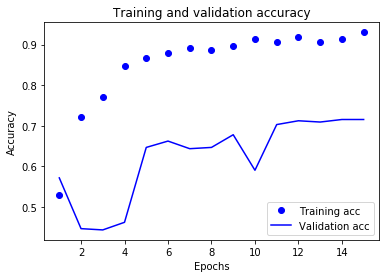

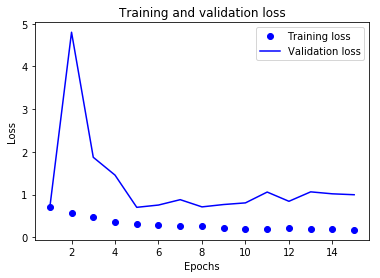

In [67]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show();

## Evaluation on test set

In [68]:
results = model.evaluate(X_test, y_test)

400/400 [==============================] - 2s 4ms/step


In [69]:
loss = results[0]
accuracy = results[1]

In [70]:
loss

1.0879570579528808

In [71]:
accuracy

0.67

## Save the model and tokenizer

In [ ]:
model.save("HospitalErrorDetectionMultiAttributeClassifier.h5")

In [ ]:
with open('HospitalErrorDetectionMultiAttributeTokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL, fix_imports=True)